In [1]:
import numpy as np

# Set parameters
frequency = 10  # Hz
amplitude_mV = 100  # mV
duration = 1  # s

# Generate sine wave
t = np.linspace(0, duration, int(duration * 1000), endpoint=False)
signal = amplitude_mV * np.sin(2 * np.pi * frequency * t)

# Calculate amplitude in mVrms
amplitude_mVrms = np.sqrt(np.mean(np.square(signal)))

# Print results
print(f"Amplitude in mV: {amplitude_mV:.2f} mV")
print(f"Amplitude in mVrms: {amplitude_mVrms:.2f} mVrms")


Amplitude in mV: 100.00 mV
Amplitude in mVrms: 70.71 mVrms


模型：
$$ P_{z-1st} = 0.0064(pT^{-1})\times B_0  ~~\% B0 = 100pT$$
$$ I_{PD-1st}(t) = 337.2(mV) \times P_{z-1st} $$


In [21]:
12/15**2

0.05333333333333334

In [12]:
60/90**2*100*0.68*0.176

0.08865185185185186

In [25]:
2.158/0.0064

337.18749999999994

In [1]:

import matplotlib.pyplot as plt
from numpy.random import normal
import numpy as np

from numpy.random import randn
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise

from filterpy.kalman import JulierSigmaPoints

from filterpy.kalman import MerweScaledSigmaPoints

from filterpy.kalman import UnscentedKalmanFilter as UKF

In [2]:
## Parameter define

nDensity = 6.0952 * 1e13 # cm-3
Ipump = 5 # mW
eta = 1 # PD convsertion 
L = 3 * 1e-2 # cm
sigma_op = 2.34601 * 1e-13 # cm2

## Model state init

S0 = 0.7

timeInterval = 1e-4

## Magnetic param

def magnetic(t):
    t = np.asarray(t)
    return 5*np.sin(10*t)


In [3]:
## Single Pump atomic magnetormeter Model

def fx(x, dt):
    '''
    input: x = (time, Bx, Pz), dt = time interval
    output: update x
    '''
    x_update = np.empty_like(x)
    x_update[0] = x[0] + dt
    x_update[1] = magnetic(x[0]+dt)
    x_update[2] = 0.34 * S0 * x_update[1]/(1+x_update[1]**2) + S0
    return x_update

def hx(x):
    '''
    observe function, transfer the polarization to voltage of PD
    '''
    V_PD = eta * Ipump * np.exp(-nDensity * sigma_op * L * (1-x[2]))
    return [V_PD]
    
    

In [4]:
### UKF & sample points

points = MerweScaledSigmaPoints(n=3, alpha=.1, beta=2., kappa=-1)
ukf = UnscentedKalmanFilter(dim_x=3, dim_z=1, dt=timeInterval, hx=hx, fx=fx, points=points)

### UKF setting & experiment
ukf.x = np.array([0., 0., S0]) # state init
ukf.R = np.diag([0.01]) # measurement noise
ukf.Q = Q_discrete_white_noise(3, dt=0.1, var=0.001) # process noise


In [5]:
## Tracking , time unit: s? ms?
Nnum = int(3e4)

time = [i*timeInterval for i in range(Nnum)]
Bz = [magnetic(t) for t in time]

Pz = []
Voltage = []
for i in Bz:
    Pz_next = 0.34 * S0 * i/(1+i**2) + S0
    Pz.append(Pz_next)
    Voltage.append(eta * Ipump * np.exp(-nDensity * sigma_op * L * (1-Pz_next)))
    


Voltage_measure = [i + randn()*0.01 for i in Voltage]


In [6]:
## UKF & plot

uxs = []
uys = []
for z in Voltage_measure:
    ukf.predict()
    ukf.update(z)
    uxs.append(ukf.x.copy())
    uys.append(hx(uxs[-1]))
uxs = np.array(uxs)
uys = np.array(uys)



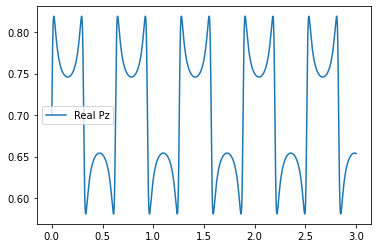

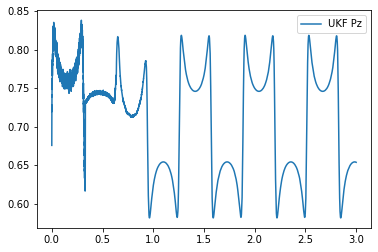

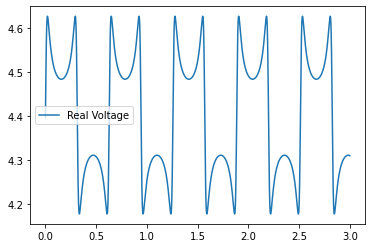

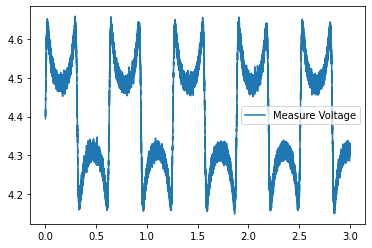

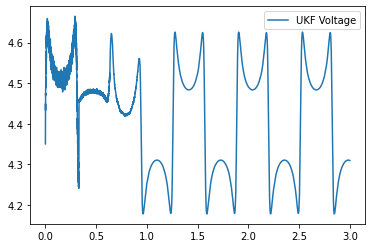

In [7]:
## plot

plt.figure()
plt.plot(time, Pz, label='Real Pz')
plt.legend()

plt.figure()
plt.plot(time, uxs[:, 2], label = 'UKF Pz')
plt.legend()


plt.figure()
plt.plot(time, Voltage, label='Real Voltage')
plt.legend()

plt.figure()
plt.plot(time, Voltage_measure, label='Measure Voltage')
plt.legend()

plt.figure()
plt.plot(time, uys, label = 'UKF Voltage')
plt.legend()


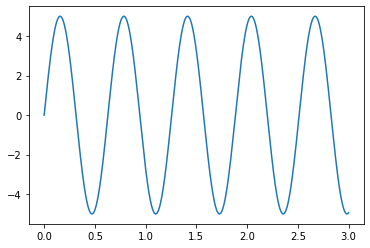

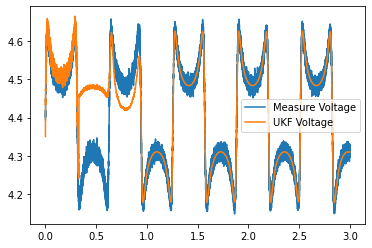

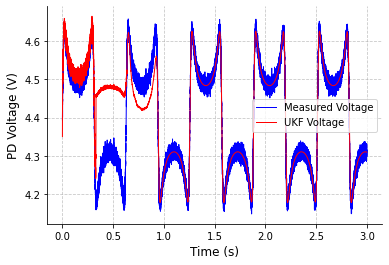

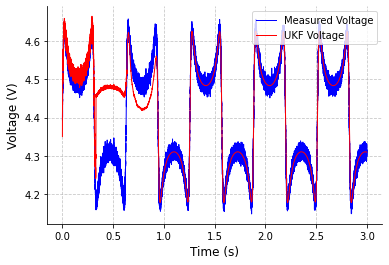

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some example data
Nnum = int(3e4)
timeInterval = 1e-4
time = [i*timeInterval for i in range(Nnum)]

# Create the plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the data
ax.plot(time, Voltage_measure, linewidth=1, color='blue', label='Measured Voltage')
ax.plot(time, uys, linewidth=1, color='red', label='UKF Voltage')

# Set the axis labels and legend
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Voltage (V)', fontsize=12)
ax.legend(fontsize=10, loc='upper right')

# Customize the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', alpha=0.7)

# Save the plot to a file
plt.savefig('plotUKF_v1.png', dpi=300, bbox_inches='tight')
